Shunyu Wu

# DATA LOADING

In [1]:
import os
path = 'dataset1_reaching-task/'
fname = os.path.join(path, 'Dataset1.mat')

from scipy.io import loadmat
DATA = loadmat(fname)

In [2]:
import numpy as np

In [3]:
DATA?

Type:        dict
String form:
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Apr 15 20:14:36 2014', ' <...>    [ 1.37384654,  3.40653601,  0.80143189, ...,  4.15004726,
           1.23933654,  3.31729972]])}
Length:      5
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)


In [4]:
%whos

Variable   Type        Data/Info
--------------------------------
DATA       dict        n=5
fname      str         dataset1_reaching-task/Dataset1.mat
loadmat    function    <function loadmat at 0x1082ed830>
np         module      <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
os         module      <module 'os' from '/Users<...>da3/lib/python3.7/os.py'>
path       str         dataset1_reaching-task/


In [5]:
DATA

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Apr 15 20:14:36 2014',
 '__version__': '1.0',
 '__globals__': [],
 'direction': array([[3],
        [5],
        [5],
        [2],
        [6],
        [3],
        [7],
        [4],
        [3],
        [4],
        [2],
        [1],
        [8],
        [5],
        [4],
        [2],
        [4],
        [7],
        [5],
        [2],
        [5],
        [1],
        [5],
        [4],
        [3],
        [6],
        [8],
        [1],
        [1],
        [3],
        [5],
        [7],
        [4],
        [1],
        [3],
        [7],
        [8],
        [5],
        [5],
        [2],
        [3],
        [7],
        [1],
        [8],
        [5],
        [3],
        [7],
        [4],
        [2],
        [5],
        [8],
        [8],
        [5],
        [7],
        [7],
        [4],
        [2],
        [6],
        [4],
        [6],
        [6],
        [5],
        [4],
        [3],
        [5],
   

In [6]:
firing_rate = DATA['R'].T
direction = DATA['direction']

In [7]:
firing_rate.shape

(158, 143)

In [8]:
import matplotlib.pyplot as plt

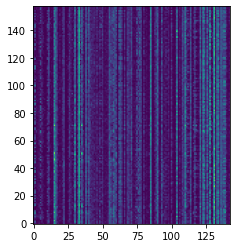

In [9]:
plt.imshow(firing_rate, origin='lower')

# 1

In [10]:
# first neuron
direction_mean = np.zeros(8)
for i in range(1,9):
    direction_mean[i-1] = firing_rate[(direction == i).flatten()][:,0].mean()

In [11]:
direction_mean

array([3.71823604, 2.33841363, 0.94966148, 0.74470821, 0.51546053,
       0.61088455, 4.36236034, 5.23958888])

Text(0, 0.5, 'firing rate mean')

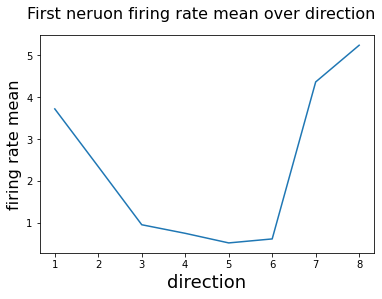

In [12]:
fig = plt.figure()
plt.plot(range(1,9), direction_mean)
fig.suptitle('First neruon firing rate mean over direction', fontsize=16)
plt.xlabel('direction', fontsize=18)
plt.ylabel('firing rate mean', fontsize=16)

# 2

In [13]:
# 2
neuron_1 = firing_rate[:,0]
neuron_2 = firing_rate[:,1]

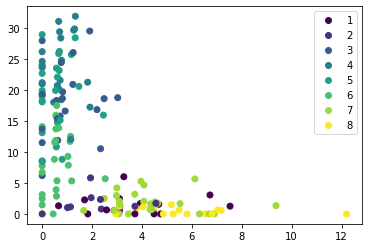

In [14]:
scatter = plt.scatter(neuron_1, neuron_2, c = direction)
classes = ['1','2','3','4','5','6','7','8']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)


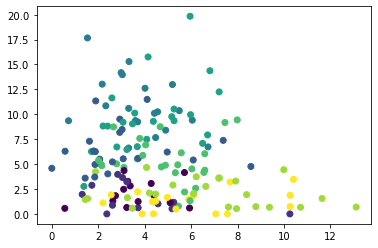

In [15]:
scatter = plt.scatter(firing_rate[:,36], firing_rate[:,10], c = direction)

# 3

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data_norm = StandardScaler().fit_transform(firing_rate) #normlize

pca = PCA(n_components = 10)
data_pca = pca.fit_transform(data_norm)

data_pca.shape

(158, 10)

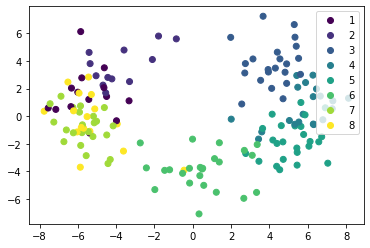

In [37]:
# scatter = plt.scatter(data_pca[:,0], data_pca[:,1])
scatter = plt.scatter(data_pca[:,0], data_pca[:,1], c = direction)
classes = ['1','2','3','4','5','6','7','8']
plt.legend(handles=scatter.legend_elements()[0], labels=classes, loc='upper right')


In [18]:
exp_var_pca = pca.explained_variance_ratio_
exp_var_pca

array([0.17104218, 0.05861031, 0.05056524, 0.04312119, 0.02938648,
       0.02432994, 0.02184124, 0.01965676, 0.01905571, 0.01839738])

In [19]:
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
cum_sum_eigenvalues

array([0.17104218, 0.2296525 , 0.28021774, 0.32333893, 0.35272541,
       0.37705535, 0.39889659, 0.41855335, 0.43760906, 0.45600644])

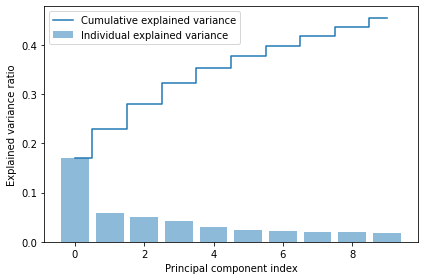

In [20]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

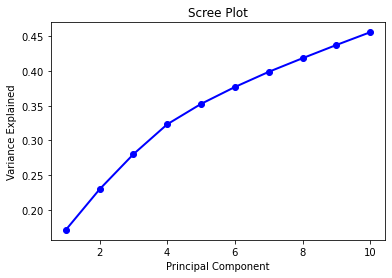

In [21]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, cum_sum_eigenvalues, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# 4

In [38]:
direction_mean = np.zeros((143, 8))
for j in range(143):
    for i in range(1,9):
        direction_mean[j][i-1] = firing_rate[(direction == i).flatten()][:,j].mean()


In [88]:
direction_mean.T.shape

(8, 143)

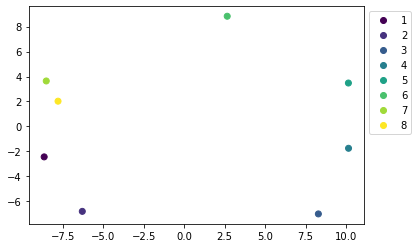

In [94]:
dir_based = StandardScaler().fit_transform(direction_mean.T)
pca_d = PCA(n_components = 2)
dir_pca = pca_d.fit_transform(dir_based)


scatter = plt.scatter(dir_pca[:,0], dir_pca[:,1], c = [1,2,3,4,5,6,7,8])
classes = ['1','2','3','4','5','6','7','8']
plt.legend(handles=scatter.legend_elements()[0], labels=classes, bbox_to_anchor =(1, 1))


In [95]:

exp_var_pca_d = pca_d.explained_variance_ratio_
cum_sum_eigenvalues_d = np.cumsum(exp_var_pca_d)


# direction 1 pca


In [147]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    temp_d = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))/np.pi*180
    if temp_d > 90:
        temp_d = 180 - temp_d
    return temp_d

# cluster 

In [133]:
dirs = {}
pca = PCA(n_components = 2)

In [137]:
pca = {}

In [138]:
for i in range(1,9):
    dn = StandardScaler().fit_transform(firing_rate[(direction == i).flatten()])
    pca[i] = PCA(n_components = 2)
    dirs[i] = pca[i].fit_transform(dn)


In [ ]:
angle_between(pca[1].components_[1], direction_mean.T)

In [151]:
for i in range(1,7):
    print(min(angle_between(pca[i].components_[1], direction_mean.T[i-1]-direction_mean.T[i]), angle_between(pca[i].components_[0], direction_mean.T[i-1]-direction_mean.T[i])))
    print(min(angle_between(pca[i+1].components_[1], direction_mean.T[i]-direction_mean.T[i-1]), angle_between(pca[i+1].components_[0], direction_mean.T[i]-direction_mean.T[i-1])))

82.87186985409313
79.80395262732472
74.57712809714097
72.97172039294902
80.12186206488173
82.91496940845954
79.79045895638579
77.15904047196733
72.76161502534808
68.23347737433338
61.04547579293305
75.08827067891333


# LDA

/Users/a0/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


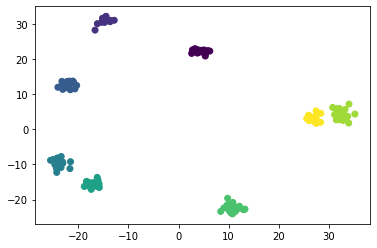

In [161]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(firing_rate,direction)
X_new = lda.transform(firing_rate)
plt.scatter(X_new[:, 0], X_new[:, 1],marker='o',c=direction)
plt.show()

# 7 Turing neurons

In [ ]:
def tuning_function(x, mu, kappa, fmax, bsl):
    # Von Mises, with kappa the concentration, mu the location
    # fmax the firing rate at pref ori, bsl the min firing rate (not the baseline, which was substracted) 
    tf = bsl + np.exp(kappa*(np.cos(x-mu)-1)) * (fmax-bsl)
    return tf

from lmfit import Model, Parameters

def fit_tc(array, init_kappa):
    x = np.linspace(0, 2*np.pi, len(array), endpoint=False)
    mod = Model(tuning_function)
    pars = Parameters()
    #               name    default           vary  min   max
    pars.add_many(('mu', x[np.argmax(array)], True, 0., 2*np.pi),
                  ('kappa', init_kappa, True,  .1, 10.),
                  ('fmax', np.max(array), True, 0.0, 2*np.max(array)+5),
                  ('bsl', np.min(array), True, 0.0, np.max(array)+5))
    out = mod.fit(array, pars, x=x, nan_policy='omit', max_nfev=50000)

    return out.best_values


In [ ]:
out = fit_tc(direction_mean[0], 3.5)
out

In [ ]:
p = tuning_function(theta_more, out['mu'], out['kappa'], out['fmax'], out['bsl'])

In [ ]:
theta = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_more = np.linspace(0,2*np.pi, 60, endpoint = False)

In [ ]:
plt.plot(direction_mean[0], '.')
plt.plot(theta_more, p)

In [ ]:
x = np.linspace(0, 2*np.pi, 8)
x

In [ ]:
p

In [ ]:
for i_neuron in range(8):
    p = fit_tc(direction_mean[i_neuron, :], 1.5)

    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(theta, direction_mean[i_neuron, :] , '.')
    ax.plot(theta_more, tuning_function(theta_more, **p))
    ax.set_xlabel('direction')
    ax.set_ylabel('Mean firing rate')
    ax.set_ylim(0)
    plt.show()

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot( theta - out['mu'])

In [ ]:
mu_list = np.empty(143)
kappa_list = np.empty(143)
for i in range(143):
    out = fit_tc(direction_mean[i], 1)
    mu_list[i] = out['mu']
    kappa_list[i] = out['kappa']

In [ ]:
# distrubition of mu
plt.hist(mu_list*180/np.pi)


In [ ]:
plt.hist(kappa_list)